# Household Object Image Classification: Computer Vision for Home Applications

## Abstract
As Computer Vision develops alongside the increasing prevalence of cheap edge computing devices, we are seeing more innovative CV use cases that can be deployed on relatively cheap edge devices in the home such as Ring doorbells. Most models focus on detection of an individual to start a recording or send a notification; this project intends to expand that list to include detection of people, cats, dogs, backpacks, and potted plants.

This would allow models to expand their ability to recognize and interpret scenes while offering users additional functionality to monitor pet behavior and track the location of household items or the health of plants in their home by recognizing whether the image contains a certain category.


In [109]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from skimage.feature import hog, daisy

import matplotlib.pyplot as plt
import pylab
from tqdm.auto import tqdm


import cv2
import skimage

In [43]:
def visualize_ims(im_collection):
    # create multi-row figure
    plt.figure(figsize=(25, 3))


    # add images to the figure from the stack
    for i in range(1, len(im_collection)+1):
        plt.subplot(1, len(im_collection), i)

        # don't forget to set the cmap, vmin, vmax, and axis off
        plt.imshow(im_collection[i-1], cmap="gray")
        plt.axis("off")


    plt.show()

In [72]:
dataDir='/Users/grantwilson/Desktop/datasets/coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [73]:
coco=COCO(annFile)
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture food animal indoor vehicle outdoor kitchen electronic appliance person accessory sports


In [79]:
# get all images containing given categories, select one at random
ids = set()
cat_ids = []
for category in ['person','dog','cat', "backpack", "potted plant"]:
    catIds = coco.getCatIds(catNms=category)
    cat_ids.append(catIds[0])
    imgIds = coco.getImgIds(catIds=catIds )
    [ids.add(i) for i in coco.getImgIds(imgIds = imgIds)]
    print(f"{category} {len(imgIds)}")
ids = list(ids)

person 2693
dog 177
cat 184
backpack 228
potted plant 172


## Dataset - cocodataset.org
The COCO dataset comes in a variety of image sizes and resolutions. To standardize the data, we’ll have to create a pipeline to enforce image size/resolutions and other preprocessing steps as necessary. We plan on utilizing histograms of oriented gradients and Canny edge detection to identify objects within the image and textural features to aid in image classification across our categories.


In [47]:
images = np.load("image.npy")
image_labels = np.load("image_category.npy")

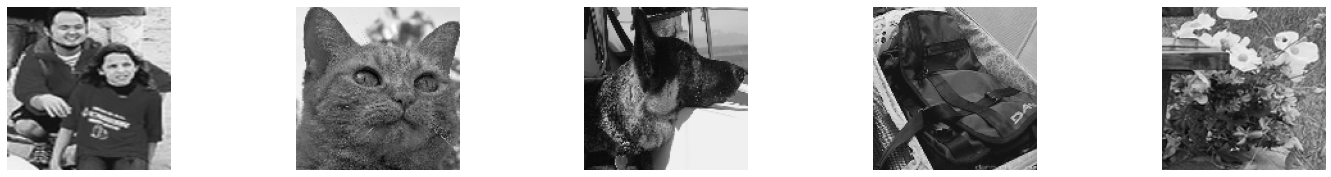

In [69]:
example_images = [10, 2965, 718, 714, 773]
example_image_collection = images[example_images]
visualize_ims(example_image_collection)

### Preprocessing
Our project included testing and extraction of many types of features to build out a successful classifier. The COCO dataset offers a significant number of images that include people, pets, and other household items, however these images are not isolated to a single image. To make things easier for our classifier we extracted our preselected categories from the image, ensured they would be sufficiently large to extract features, and standardized their shape.


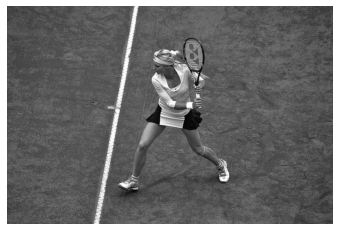

In [91]:
img = coco.loadImgs(ids[1099])[0]

I = io.imread(img['coco_url'], as_gray=True)
plt.axis('off')
plt.imshow(I, cmap="gray")
plt.show()

Since the COCO images include pose estimation and bounding boxes of figures within the image, it made feature extraction a fairly simple process. We can easily use the bounding box to extract a single person feature and resize it to work within our model.

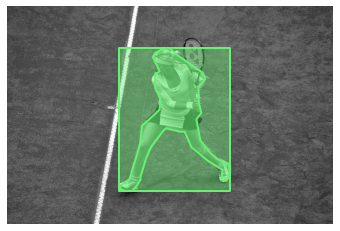

In [92]:
plt.imshow(I, cmap="gray"); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

Image categories were also a significant issue. Given the nature of the COCO photos, we had severely imbalanced classes. Most of our photos were of people and the first few baseline models demonstrated that when our classifier refused to predict an image as anything other than a person. We went back to preprocessing and randomly selected indices of people-images and selected only as many people as our largest minority class. 

<BarContainer object of 5 artists>

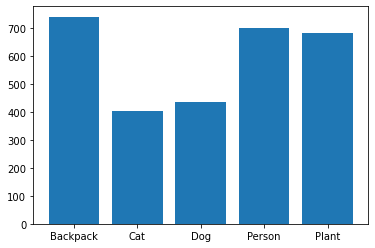

In [70]:
cats = {
    1:"Person",
    17:"Cat",
    18:"Dog",
    27:"Backpack",
    64:"Plant"
}
a = np.vectorize(cats.get)(image_labels)

unique, counts = np.unique(a, return_counts=True)
plt.bar(unique, counts)

![standard_people](final_report/image_preprocessing.png)

To up-sample our other categories we also horizontally flipped images of cats, dogs, backpacks, and potted plants. This allowed us to double the size of those classes while providing the model mirrored data that would generalize to new images.

![og_image](final_report/flipped_im.png)

![flipped_im](final_report/Original_im.png)

### Feature Extraction
Once we completed the feature preprocessing, we were able to start developing and testing features. To aid in the explanation of our model features, I will be using an image of a cat I found in the COCO dataset that I have decided to name Frank. Since our model would be focusing on the shapes and contours that comprise people, pets, and household items, we were interested in various features that would identify edges, gradients, and shapes within the image.


#### Canny Features

In [106]:
canny_feats = np.zeros(images.shape)
for im in range(0,images.shape[0]):
    edges = cv2.Canny(np.uint8(images[im]*255),100,200, L2gradient = True)
    canny_feats[im,:,:] = edges

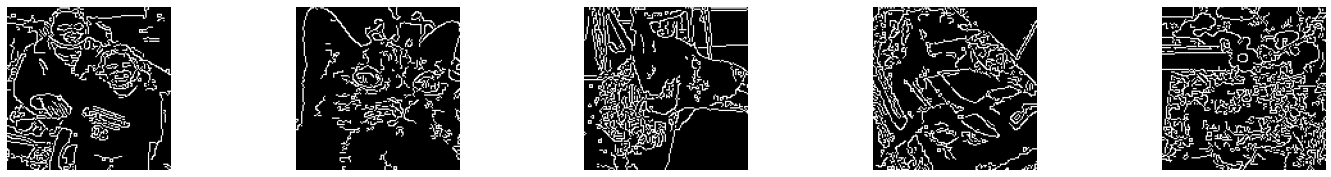

In [107]:
visualize_ims(canny_feats[example_images])

We tested a variety of Canny thresholds to create definitive edges to pass into our classifier. Once we passed them to our model, we saw significant overfitting and poor performance. Though Canny features generally helpful for tracing our image subjects, they had far too much detail to be helpful in our classification, especially outsideof our Person, Cat, and Dog classes. While Canny works to some dergree on those classes, it's pretty undecipherable when it comes to Backpacks and Plants.

This is likely a result of how we did our preprocessing. Since we cropped and resized all our images to include solely one category, there's significantly less noise in the baseline images. As we're only interested in high level features like ears or a head, the canny features detecting facial details wasn't incredibly helpful.

The next step in feature extraction was to try aggregating these features into Histogram of Oriented Gradients feeatures. This would deal with the detail issue and hopefully present a better idea of key category features.

#### HOG Features

In [104]:
im_hog = []
for i in range(0, images.shape[0]):
    im_hog.append(skimage.feature.hog(images[i], visualize=True)[1])

im_hog = np.array(im_hog)

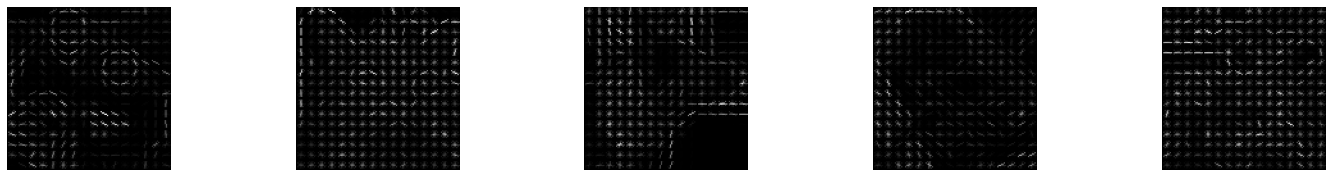

In [105]:
visualize_ims(im_hog[example_images])

Our Histogram of Oriented Gradients features ended up looking the best when it came to deciphering features from our images. Looking at our "living" classes with People, Dogs, and Cats we clearly see heads, ears, and eyes. This makes the classification a little more difficult between classes as we'll discuss later, but we're starting to extract reasonable features from our images.

We wanted to see if we could further extract individual features within these histograms so we tried out a Bag of Words approach.

#### Daisy Features

In [ ]:
daisy_ims = [daisy(i, visualize=True) for i in example_image_collection]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


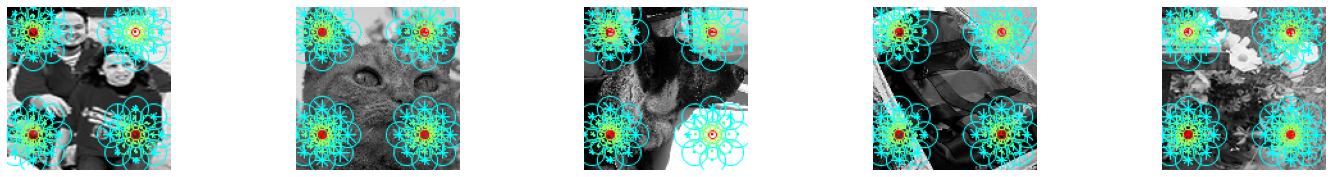

In [151]:
daisy_viz = []
for i in example_image_collection:
    daisy_viz.append(daisy(i, visualize=True, step = 80, radius = 20)[1])
    
daisy_viz = np.array(daisy_viz)
visualize_ims(daisy_viz)

Seeing the success of HOG on our image dataset, we wanted to test what something like DAISY, a dense representation of scale-invariant features, would do for our model. As we heavily leaned into the preprocessing and isolated just the image we were interested in classifying, DAISY wasn’t operating on particularly dense features and didn’t result in significant results that would’ve been useful to the model. However, Frank does look kinda cool with a flower in his hair.

# Classification - 40 pts
This part should include code to perform classification using at least two methods learned in class,
plots showing the results of classification per category, a discussion of possible reasons why the
classifier might work better for some categories than others, and explanation of the limitations of
the classifier.

#### PCA & tSNE

#### MLP Results

#### SVC Results

# Generalizability - 10 pts
Your data should be split into train, validation, and test groups before training the classifier, and you
should do a hyperparameter search using parts of the validation set, ideally in a way that avoids over-
fitting and maximizes generalizability. Lastly, you will report performance on the test set, and include
a discussion of whether you achieved generalizability and how your training process might be
improved.

#### Hyperparameter Tuning

#### Overfitting

![](final_report/MLP_Canny.png)

#### Limitations